<a href="https://colab.research.google.com/github/PhiLNNT/Academic/blob/Linear-Support-Vector-Machines/SVM_for_binary_classify_with_leukemia_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare code

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import accuracy_score
time_run_leu=dict()
result_leu=dict()
time_run_colon=dict()
result_colon=dict()

In [ ]:
##
class SVM():
  def __init__(self,X,y):
    self.m,self.n=X.shape
    self.X=X
    self.y=y.reshape((-1,1))

  def predict(self, X_test):
    # self.X_test=X_test
    # w_hat=np.vstack((self.w,self.b))
    # X_test_hat=np.concatenate((self.X_test,np.ones((self.X_test.shape[0],1))),axis=1)
    y_test=X_test@self.w+self.b
    y_test= np.where(y_test>0,1,-1)
    return y_test.flatten()


  #---solving by primal problem with CVXOPT
  def primal(self,C):
    m,n=self.m,self.n
    X_train=self.X
    y_train=self.y
      # P
    P=np.eye((m+n+1))
    P[n:]=0
    # print(P)
    P=matrix(P)

    # C*q
    q=np.zeros((m+n+1,1))
    q[n+1:]=1
    # C=100 # hyperparameter
    # print(q)
    q=matrix(C*q)

    # G
    yX=y_train*np.concatenate((X_train,np.ones((m,1))),axis=1)
    yX=np.concatenate((yX,np.eye(m)),axis=1)
    k=np.eye(yX.shape[1],k=n+1)
    k=k[:m,:]

    G=-np.concatenate((yX,k))
    m_G,n_G=G.shape

    # print(G)
    G=matrix(G)


    # h
    h=-np.ones((m_G,1))
    h[m:]=0
    h=matrix(h)
    # print(h)

    #--solver--
    solvers.options['show_progress'] = True
    # solvers.options['refinement']=1
    sol=solvers.qp(P, q, G, h)
    w = np.array(sol['x'])[:n+1]
    # print('w = ',w[:n].flatten())
    # print('b = ',w[-1])
    return w[:n],w[-1]

  #---solving by primal problem has R=l1-norm with CVXOPT
  def primal_R(self,alpha,C):
    X=self.X
    y=self.y
    m,n = self.m,self.n # m samples, n features
    N= 2*n+m+1 # dim z

      # build P
    P1=np.eye(2*n,k=n)
    P2=np.eye(2*n,k=-n)
    P=np.zeros((N,N))
    P12 = np.eye(2*n)-P1-P2
    P[:2*n,:2*n]=P12
    P=matrix(P)
    # print(P)

    # Build q
    q=np.zeros((N,1))
    q[:2*n]=alpha
    q[2*n+1:]=C
    q=matrix(q)

    # print(q)

    #build G
    G=np.zeros((2*n+2*m,2*n+m+1))
    eta=np.eye(m)
    uv=np.hstack((X,-X))
    yz=y*np.hstack((uv,np.ones((m,1))))
    yzeta=np.hstack((yz,eta))
    u=np.eye(n)
    G[:m,]=yzeta
    G[m:m+n,:n]=u
    G[m+n:m+2*n,n:2*n]=u
    G[m+2*n:,2*n+1:]=eta
    G=matrix(-1.*G)

    # print(G)

    #build h
    h=np.zeros((2*n+2*m,1))
    h[:m]=-1
    h=matrix(h)
    # print(h)

    #sovle
    solvers.options['show_progress'] = True
    solvers.options['abstol'] = 1e-10
    solvers.options['reltol'] = 1e-10
    solvers.options['feastol'] = 1e-10
    sol=solvers.qp(P=P, q=q, G=G, h=h,kktsolver='ldl')
    z = np.array(sol['x'])[:2*n+1]
    u_solution =z[:n]
    v_solution = z[n:2*n]
    u1_solution = np.maximum(u_solution,0)
    v1_solution = np.maximum(-v_solution,0)
    w=u_solution-v_solution
    return w,z[-1]

  #---solving by dual problem with CVXOPT
  def dual_solve(self,C):
    X=self.X
    y=self.y
    m,n = self.m,self.n
    y = y.reshape(-1,1) * 1.
    X_dash = y.reshape((-1,1)) * X
    H = np.dot(X_dash , X_dash.T) * 1.

    #Converting into cvxopt format
    P = matrix(H)
    q = matrix(-np.ones((m, 1)))
    G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))

    #Setting solver parameters (change default to decrease tolerance)
    # solvers.options['show_progress'] = False
    # solvers.options['abstol'] = 1e-10
    # solvers.options['reltol'] = 1e-10
    # solvers.options['feastol'] = 1e-10

    #Run solver
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])

    #Compute w,b
    w = ((y * alphas).T @ X).reshape(-1,1)
    S = (alphas > 1e-5).flatten()
    b = (y[S] - np.dot(X[S], w))
    # print('Alphas = ',alphas)
    # print('w = ', w)
    # print('b = ', b[0])
    return w , b[0]

  #--Solving by subgradient

  #-- compute subgradient of g(x)=max(0,f(x))
  def subgrag(self,w_hat):
    X=self.X
    y=self.y
    m,n = self.m,self.n
    w=w_hat[:-1]
    b=w_hat[-1]
    U = y*(X@w+b)
    # print('U2',U)
    z=(U>1).flatten()
    zz=(U==1).flatten()
    # g=np.copy(u)
    g=-y*(np.hstack((X,np.ones((m,1)))))
    # print(g)
    g[z]=0
    g[zz]=np.random.rand(g[zz].shape[0],1)*g[zz]
    # print(g)
    return g.T

  #-- compute subgradient of R(x)=l1-norm
  def subgraR(self,w_hat):
    X=self.X
    y=self.y
    m,n = self.m,self.n
    w=w_hat[:-1]
    r=np.where(w!=0,np.sign(w),np.random.uniform(-1,1))
    # r=np.where(w!=0,np.sign(w),0)
    return np.vstack((r,0))

  #--cost function
  def cost(self,w_hat,alpha,C,R):
    X=self.X
    y=self.y
    m,n = self.m,self.n
    w=w_hat[:-1]
    b=w_hat[-1]
    U = y*(X@w+b)
    # print('U1',U)
    if R:
      return 0.5*np.sum(w*w)+ C*(np.sum(np.maximum(0, 1 - U)))+alpha*(np.sum(abs(w)))
    else:
      return 0.5*np.sum(w*w)+ C*(np.sum(np.maximum(0, 1 - U)))

  #--compute subgradient of cost function
  def subgradient(self,w_hat,alpha,C,R):
    X=self.X
    y=self.y
    m,n = self.m,self.n
    w=w_hat[:-1]
    b=w_hat[-1]
    U = y*(X@w+b)
    if R:
      r=self.subgraR(w_hat)
      g=self.subgrag(w_hat)
      sub = w_hat+C*np.sum(g,axis=1,keepdims=True)+alpha*r
      sub[-1]-=b
    else:
      g=self.subgrag(w_hat)
      sub = w_hat+C*np.sum(g,axis=1,keepdims=True)
      sub[-1]-=b
    return sub

  #--subgradient descent
  def subgrad_descent(self,w0,b0,alpha,C,R,learning_rate,max_time):
    X=self.X
    y=self.y
    m,n = self.m,self.n
    w=w0
    b=b0
    w_hat=np.vstack((w,b))
    it=0
    lst_cost=[]
    lst_cost.append(self.cost(w_hat,alpha,C,R))
    while it<max_time:
      last_cost=self.cost(w_hat,alpha,C,R)
      it += 1
      old_w_hat=w_hat.copy()
      sub = self.subgradient(old_w_hat,alpha,C,R)
      #-- modify learning rate
      # if it>5000:
      #   learning_rate = learning_rate/(np.log(np.sqrt(it)))
      w_hat -= learning_rate*sub
      new_cost=self.cost(w_hat,alpha,C,R)
      lst_cost.append(new_cost)
      # print('12334',np.linalg.norm(sub))
      if it % 1000 ==1:
        print('iter %d' %it + ' cost: %f' %new_cost)
      # if abs(new_cost-last_cost)<1e-20:
      #   new_cost=last_cost
      #   # w_hat=old_w_hat
      #   # it-=1
      #   print('Stopped by early stopping at ',it,'-th iterattion')
      #   print('iter %d' %(it-1) + ' cost: %f' %last_cost)
      #   print('iter %d' %it + ' cost: %f' %new_cost)
      #   break
      if np.linalg.norm(sub)<1e-5:
        print('Stopped by objective value at ',it,'-th iterattion')
        break
    else:
      # if new_cost>last_cost:
      #   new_cost=last_cost
      #   w_hat=old_w_hat
        print('Stopped by max iteration')
    return w_hat[:-1],w_hat[-1],lst_cost,it

  #--main solver--
  def solver(self,key=0, dual=None, C=100,alpha=0.01, learning_rate=0.01,max_time=200000,Reg=None, subgradient_method=None,w0=0,b0=0):
    '''
    key==0: solved by primal problem with Reg=0
    key==1: solved by primal problem with Reg=l1-norm
    key==2: solved by unconstranted problem with Reg=0
    key==3: solved by unconstranted problem with Reg=l1-norm
    key==4: solved by dual problem with Reg=0
    '''
    if key == 1:
      print('solved by primal problem with Reg=l1-norm')
      self.w, self.b=self.primal_R(alpha,C)
      return self.w, self.b
    if key==3:
      print('solved by unconstranted problem with Reg=l1-lorm')
      self.w, self.b,lst_cost,it=self.subgrad_descent(w0,b0,alpha,C,Reg,learning_rate,max_time)
      return self.w, self.b,lst_cost,it
    if key==0:
      print('solved by primal problem with Reg=0')
      self.w, self.b=self.primal(C)
      return self.w, self.b
    if key==2:
      print('solved by unconstranted problem with Reg=0')
      self.w, self.b,lst_cost,it=self.subgrad_descent(w0,b0,alpha,C,Reg,learning_rate,max_time)
      return self.w, self.b,lst_cost,it
    if Reg != None and dual != None:
        raise Exception(' doesn\'t support dual with Reg = l1-norm'  )
    if key==4:
      print('solved by dual problem with Reg=0')
      self.w, self.b =self.dual_solve(C)
      return self.w, self.b


# Working with datas

In all trainings, we set $C=100$ and $\alpha=0.01$

# Working with Leukemia dataset

## Prepare data

In [ ]:
!pip install wget
import wget
from os import path
!pip install libsvm
from libsvm.svmutil import svm_read_problem
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer


  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=0e79b8b6d27c6918af7036473e92e3dc9d17fd04902245956dc984be36317479
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 170 kB 5.1 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233370 sha256=d60914926771b2dd75f06b247f742eb97969d80bc9f835d73ccc2bfc644b6b75
  Stored in directory: /root/.cache/pip/wheels/cd/e8/1e/bf95cf256e4d3ffc94289ab508c49d48e34c98220af63e3513
Successfully built libsvm


In [ ]:
# get trainning data
wget.download('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/leu.bz2','leu.bz2')

'leu.bz2'

In [ ]:
# get testing data
wget.download('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/leu.t.bz2','leu.t.bz2')


'leu.t.bz2'

In [ ]:
# unzip data
!bunzip2 leu.bz2
!bunzip2 leu.t.bz2


In [ ]:
# get training data
y_train_leu, X_train_leu = svm_read_problem('leu')
v = DictVectorizer(sparse=False)
X_train_leu = v.fit_transform(X_train_leu)

# # get testing data
y_test_leu, X_test_leu = svm_read_problem('leu.t')
# v = DictVectorizer(sparse=False)
X_test_leu = v.transform(X_test_leu)





In [ ]:
# of classes: 2
# of data: 38 / 34 (testing)
# of features: 7129

y_train_leu=np.array(y_train_leu)
y_test_leu=np.array(y_test_leu)

print(X_train_leu.shape)
print(y_train_leu.shape)

print(X_test_leu.shape)
print(y_test_leu.shape)



(38, 7129)
(38,)
(34, 7129)
(34,)


## Task 1: Use  a  solver  to  train with $R=  0 $ and $R=\alpha ‖·‖_1$

### Use CVXOPT Solvers.qp to train with $R=0$

In [ ]:
#--measure time to run code
start_time = time.time()

#--train--
task_leu=SVM(X_train_leu,y_train_leu)
w,b=task_leu.solver()
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_leu['primal']=elapsed_time
print('Running time:',time_run_leu['primal'])

#- save w,b
result_leu['primal']=(w,b)

#--predict
y_predict_leu=task_leu.predict(X_test_leu)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_leu.reshape(-1,),y_test_leu.reshape(-1,))*100))



solved by primal problem with Reg=0
     pcost       dcost       gap    pres   dres
 0: -3.7995e+05  3.8100e+03  8e+03  1e+02  1e+00
 1: -6.1216e+03 -7.5049e+01  2e+02  2e+00  2e-02
 2: -1.1157e+02 -6.0402e+00  1e+01  4e-02  4e-04
 3:  9.2098e-01 -7.8048e-01  2e+00  2e-13  1e-13
 4:  1.4266e-01 -1.0285e-01  2e-01  6e-14  2e-15
 5:  2.4104e-02 -1.0802e-02  3e-02  4e-14  2e-15
 6:  5.2746e-03  5.1808e-04  5e-03  1e-14  2e-15
 7:  2.0336e-03  1.5493e-03  5e-04  4e-15  2e-15
 8:  1.6462e-03  1.6068e-03  4e-05  2e-15  2e-15
 9:  1.6189e-03  1.6159e-03  3e-06  2e-15  2e-15
10:  1.6173e-03  1.6171e-03  2e-07  1e-15  2e-15
11:  1.6172e-03  1.6172e-03  1e-08  2e-15  2e-15
Optimal solution found.
w: [[-1.26708919e-03]
 [-3.15899694e-04]
 [ 4.42377693e-04]
 ...
 [ 9.00043927e-05]
 [-2.47749502e-03]
 [-1.30369566e-04]]
b: [0.42770494]
Running time: 58.1010947227478
accuracy:82.35 %


### Use CVXOPT Solvers.qp to train with $R=\alpha ‖·‖_1$

In [ ]:
#--measure time to run code
start_time = time.time()

#--train--
task1_leu=SVM(X_train_leu,y_train_leu)
w,b=task1_leu.solver(key=1)
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_leu['primal_R']=elapsed_time
print('Running time:',time_run_leu['primal_R'])

#- save w,b
result_leu['primal_R']=(w,b)

#--predict
y_predict_leu=task_leu.predict(X_test_leu)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_leu.reshape(-1,),y_test_leu.reshape(-1,))*100))




solved by primial problem with Reg=l1-norm


## Task2: Use the subgradient method to solve this problem

### $R=0$

#### if we choose $(w_0,b_0)=(0,...,0)$ the accuracy seems to be unchanged even though the optimal solution is not exact.

In [ ]:
#--measure time to run code
start_time = time.time()

#-- create initial w0=0,b0=0
m,n=X_train_leu.shape
w0=np.zeros((n,1))
b0=0
#--train--
task_leu1=SVM(X_train_leu,y_train_leu)
w,b,lst_cost,it=task_leu1.solver(key=2,w0=w0,b0=b0,learning_rate=0.000000005,max_time=2000)
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_leu['sub']=elapsed_time
print('Running time:',time_run_leu['sub'])

#- save w,b
result_leu['sub']=(w,b)

#--predict
y_predict_leu=task_leu1.predict(X_test_leu)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_leu.reshape(-1,),y_test_leu.reshape(-1,))*100))


solved by unconstranted problem with Reg=0
iter 1 cost: 3771.184883
iter 1001 cost: 0.002738
Stopped by max iteration
w: [[-1.11527812e-03]
 [ 4.64562811e-05]
 [ 1.85188229e-04]
 ...
 [ 5.04051009e-04]
 [-2.13412721e-03]
 [-8.66598503e-05]]
b: [0.003265]
Running time: 4.3905439376831055
accuracy:82.35 %


In [ ]:
sub_solution=np.vstack((result_leu['sub'][0],result_leu['sub'][1]))
primal_solution=np.vstack((result_leu['primal'][0],result_leu['primal'][1]))

print(' distance between subgradient method solution and primal solution:', np.linalg.norm(sub_solution-primal_solution))

 distance: 0.426069629680071


#### if we choose $(w_0,b_0)=(0,...,0.41)$ the accuracy seems to be higher even though the optimal solution is not exact.

In [ ]:
#--measure time to run code
start_time = time.time()

#-- create initial w0=0,b0=0
m,n=X_train_leu.shape
w0=np.zeros((n,1))
b0=0.41
#--train--
task_leu1=SVM(X_train_leu,y_train_leu)
w,b,lst_cost_1,it_1=task_leu1.solver(key=2,w0=w0,b0=b0,learning_rate=0.000000005,max_time=2000)
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_leu['sub']=elapsed_time
print('Running time:',time_run_leu['sub'])

#- save w,b
result_leu['sub']=(w,b)

#--predict
y_predict_leu=task_leu1.predict(X_test_leu)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_leu.reshape(-1,),y_test_leu.reshape(-1,))*100))


solved by unconstranted problem with Reg=0
iter 1 cost: 3115.184883
iter 1001 cost: 0.001911
Stopped by max iteration
w: [[-0.00128605]
 [-0.00031235]
 [ 0.00022624]
 ...
 [ 0.00024386]
 [-0.00255507]
 [-0.00014742]]
b: [0.4107325]
Running time: 4.31847357749939
accuracy:91.18 %


In [ ]:
sub_solution=np.vstack((result_leu['sub'][0],result_leu['sub'][1]))
primal_solution=np.vstack((result_leu['primal'][0],result_leu['primal'][1]))

print(' distance:', np.linalg.norm(sub_solution-primal_solution))

 distance: 0.0221383554393568


distance between subgradient method solution and primal solution: 0.0221383554393568

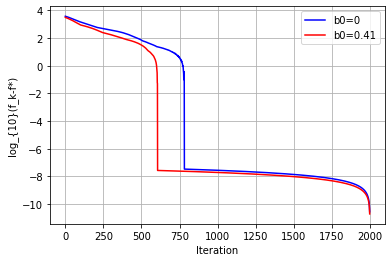

In [ ]:
## plot


import matplotlib.pyplot as plt

plt.plot([i for i in range(it)], [np.log10(i-lst_cost[-1]) for i in lst_cost[:-1]],'b-', label='b0=0')
plt.plot([i for i in range(it_1)], [np.log10(i-lst_cost_1[-1]) for i in lst_cost_1[:-1]],'r-', label='b0=0.41')
plt.xlabel('Iteration')
plt.ylabel('log_{10}(f_k-f*)')
plt.grid(True)
plt.legend()
# print(a)
plt.show()


### $R=\alpha ‖·‖_1$

In [ ]:
#--measure time to run code
start_time = time.time()

#-- create initial w0=0,b0=0
m,n=X_train_leu.shape
w0=np.zeros((n,1))
b0=0
#--train--
task_leu1=SVM(X_train_leu,y_train_leu)
w,b,lst_cost,it=task_leu1.solver(key=3,w0=w0,b0=b0,learning_rate=0.000000005,max_time=2000,Reg=1,alpha=0.0001)
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_leu['sub_R']=elapsed_time
print('Running time:',time_run_leu['sub_R'])

#- save w,b
result_leu['sub_R']=(w,b)

#--predict
y_predict_leu=task_leu1.predict(X_test_leu)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_leu.reshape(-1,),y_test_leu.reshape(-1,))*100))







solved by unconstranted problem with Reg=l1-lorm
iter 1 cost: 3771.184885
iter 1001 cost: 0.003225
Stopped by max iteration
w: [[-1.11527712e-03]
 [ 4.64558953e-05]
 [ 1.85187566e-04]
 ...
 [ 5.04050009e-04]
 [-2.13412621e-03]
 [-8.66588511e-05]]
b: [0.003265]
Running time: 4.8924925327301025
accuracy:82.35 %


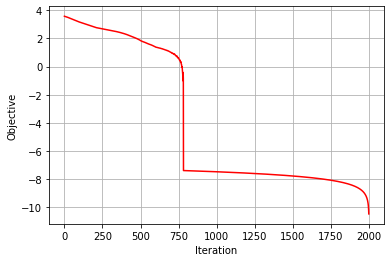

In [ ]:
## plot

import matplotlib.pyplot as plt

plt.plot([i for i in range(it)], [np.log10(i-lst_cost[-1]) for i in lst_cost[:-1]], 'b-', color='red')

plt.xlabel('Iteration')
plt.ylabel('log_{10}(f_k-f*)')
plt.grid(True)

## Task 3: Train by solve dual problem with $R=0$

In [ ]:
#--measure time to run code
start_time = time.time()

# #-- create initial w0=0,b0=0
# m,n=X_train_leu.shape
# w0=np.zeros((n,1))
# b0=0
#--train--
task_leu=SVM(X_train_leu,y_train_leu)
w,b=task_leu.solver(dual=2,key=4)
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_leu['dual']=elapsed_time
print('Running time:',time_run_leu['dual'])

#- save w,b
result_leu['dual']=(w,b)

#--predict
y_predict_leu=task_leu.predict(X_test_leu)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_leu.reshape(-1,),y_test_leu.reshape(-1,))*100))




solved by dual problem with Reg=0
     pcost       dcost       gap    pres   dres
 0:  1.6551e+01 -3.8769e+03  8e+03  1e-02  4e-14
 1:  1.5646e+01 -7.8712e+01  2e+02  2e-04  3e-14
 2:  5.2076e+00 -6.9400e+00  1e+01  4e-06  3e-14
 3:  7.8048e-01 -9.2098e-01  2e+00  2e-16  2e-14
 4:  1.0285e-01 -1.4266e-01  2e-01  1e-16  1e-14
 5:  1.0802e-02 -2.4104e-02  3e-02  2e-16  3e-15
 6: -5.1808e-04 -5.2746e-03  5e-03  2e-16  2e-15
 7: -1.5493e-03 -2.0336e-03  5e-04  2e-16  5e-16
 8: -1.6068e-03 -1.6462e-03  4e-05  1e-16  2e-16
 9: -1.6159e-03 -1.6189e-03  3e-06  2e-16  2e-16
10: -1.6171e-03 -1.6173e-03  2e-07  2e-16  2e-16
11: -1.6172e-03 -1.6172e-03  1e-08  2e-16  2e-16
Optimal solution found.
w: [[-1.26708919e-03]
 [-3.15899694e-04]
 [ 4.42377693e-04]
 ...
 [ 9.00043927e-05]
 [-2.47749502e-03]
 [-1.30369566e-04]]
b: [0.4277048]
Running time: 0.05626058578491211
accuracy:82.35 %


## Train by package sklearn.svm.SVC with $R=0$

In [ ]:
from sklearn.svm import SVC
#--measure time to run code
start_time = time.time()
print('solved by sklearn.svm.SVC')
C = 100
clf = SVC(kernel = 'linear', C = C)
clf.fit(X_train_leu, y_train_leu.reshape((-1,)))

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]
#-- save w,b
result_leu['sklearn']=(w_sklearn,b_sklearn)
print('w: ',w_sklearn)
print('b: ',b_sklearn)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_leu['sklearn']=elapsed_time
print('Running time:',time_run_leu['sklearn'])

#--predict
y_predict_leu = clf.predict(X_test_leu)

# y_predict_leu=task_leu.predict(X_test_leu)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_leu.reshape(-1,),y_test_leu.reshape(-1,))*100))

solved by sklearn.svm.SVC
w:  [[-1.26629026e-03]
 [-3.15977155e-04]
 [ 4.41701996e-04]
 ...
 [ 8.94080208e-05]
 [-2.47747125e-03]
 [-1.30397536e-04]]
b:  0.4275808701001927
Running time: 0.021550655364990234
accuracy:82.35 %


## Compare running time

<BarContainer object of 5 artists>

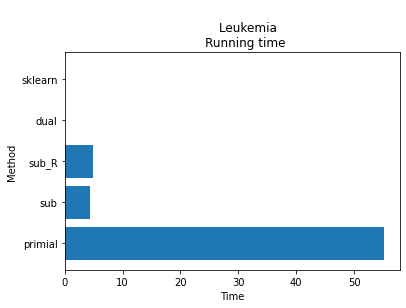

In [ ]:
fig, ax = plt.subplots()
# plt.style.use('fivethirtyeight')
ax.grid(False)

ax.set( xlabel='Time', ylabel='Method',
       title='''
        Leukemia
       Running time''')
ax.barh(list(time_run_leu.keys()), list(time_run_leu.values()))

# Working with Colon-Cancer dataset

## Prepare data

In [ ]:
!pip install wget
import wget
from os import path
!pip install libsvm
from libsvm.svmutil import svm_read_problem
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction import DictVectorizer


  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=4d1701fc05c5565c476e793afeb6ee1ed2e91a9c701a2f0a431cf360f2b3b276
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 170 kB 4.0 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233369 sha256=9d3e0eba5e42d0b1f4f443aa706fdd8b2828fdf8c7363b98d7d5e90d41cbad08
  Stored in directory: /root/.cache/pip/wheels/cd/e8/1e/bf95cf256e4d3ffc94289ab508c49d48e34c98220af63e3513
Successfully built libsvm


In [ ]:
# get trainning data
wget.download('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/colon-cancer.bz2','colon-cancer.bz2')



'colon-cancer.bz2'

In [ ]:
!bunzip2 colon-cancer.bz2


In [ ]:
y_colon, X_colon = svm_read_problem('colon-cancer')
v = DictVectorizer(sparse=False)
X_colon = v.fit_transform(X_colon)

# reshape y
y_colon=np.array(y_colon).reshape((-1,1))
# print(y.shape)




In [ ]:
# split data
from sklearn.model_selection import train_test_split
X_train_colon, X_test_colon, y_train_colon, y_test_colon = train_test_split(X_colon, y_colon, test_size=0.2, random_state=42)

# normailize
std = StandardScaler()
X_train_colon = std.fit_transform(X_train_colon)
X_test_colon = std.transform(X_test_colon)


In [ ]:
# of classes: 2
# of data: 62
# of features: 2,000
print(X_train_colon.shape)
print(y_train_colon.shape)
print(X_test_colon.shape)
print(y_test_colon.shape)


(49, 2000)
(49, 1)
(13, 2000)
(13, 1)


## Task 1: Use  a  solver  to  train with $R=  0 $ and $R=\alpha ‖·‖_1$

### Use CVXOPT Solvers.qp to train with $R=0$

In [ ]:
#--measure time to run code
start_time = time.time()

#--train--
task_colon=SVM(X_train_colon,y_train_colon)
w,b=task_colon.solver()
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_colon['primal']=elapsed_time
print('Running time:',time_run_colon['primal'])

#- save w,b
result_colon['primal']=(w,b)

#--predict
y_predict_colon=task_colon.predict(X_test_colon)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_colon.reshape(-1,),y_test_colon.reshape(-1,))*100))




solved by primal problem with Reg=0
     pcost       dcost       gap    pres   dres
 0: -4.8961e+05  5.2244e+03  1e+04  1e+02  8e-01
 1: -2.6579e+04 -3.3178e+02  8e+02  8e+00  5e-02
 2:  3.2837e+01 -2.5113e+01  6e+01  1e-13  1e-13
 3:  4.1780e+00 -3.4634e+00  8e+00  1e-13  1e-15
 4:  6.5608e-01 -4.4513e-01  1e+00  4e-14  9e-16
 5:  1.1534e-01 -4.0596e-02  2e-01  1e-14  1e-15
 6:  2.7860e-02  7.2293e-03  2e-02  5e-15  8e-16
 7:  1.2942e-02  1.1225e-02  2e-03  3e-15  9e-16
 8:  1.1699e-02  1.1559e-02  1e-04  2e-15  9e-16
 9:  1.1610e-02  1.1606e-02  4e-06  1e-15  9e-16
10:  1.1608e-02  1.1608e-02  4e-08  1e-15  1e-15
Optimal solution found.
w: [[ 0.00313486]
 [-0.00064277]
 [-0.00246084]
 ...
 [-0.00445036]
 [-0.00216626]
 [-0.00490984]]
b: [-0.49608594]
Running time: 1.9708428382873535
accuracy:84.62 %


### Use CVXOPT Solvers.qp to train with $R=\alpha ‖·‖_1$

In [ ]:
#--measure time to run code
start_time = time.time()

#--train--
task_colon=SVM(X_train_colon,y_train_colon)
w,b=task_colon.solver(key=1,alpha=0.001)
print('w:',w)
print('b:',b)
# print('count elements are nonzero',np.count_nonzero(np.vstack((w,b))))

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_colon['primal_R']=elapsed_time
print('Running time:',time_run_colon['primal_R'])

#- save w,b
result_colon['primal_R']=(w,b)

#--predict
y_predict_colon=task_colon.predict(X_test_colon)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_colon.reshape(-1,),y_test_colon.reshape(-1,))*100))




solved by primal problem with Reg=l1-norm
     pcost       dcost       gap    pres   dres
 0: -4.8948e+05  8.3451e+03  7e+05  9e+02  2e+00
 1: -2.1617e+04 -3.0536e+04  3e+04  4e+01  9e-02
 2: -7.7873e-01 -6.4144e+02  1e+03  8e-01  2e-03
 3:  1.5580e+02 -4.4960e+00  2e+02  8e-12  4e-16
 4:  2.4248e+00 -5.9604e-01  3e+00  3e-12  4e-16
 5:  2.1360e-01 -6.6487e-02  3e-01  1e-13  2e-16
 6:  4.9619e-02  7.7935e-03  4e-02  1e-14  2e-16
 7:  2.0175e-02  1.5196e-02  5e-03  4e-15  2e-16
 8:  1.7431e-02  1.6354e-02  1e-03  2e-15  2e-16
 9:  1.6760e-02  1.6689e-02  7e-05  2e-15  2e-16
10:  1.6720e-02  1.6718e-02  3e-06  2e-15  2e-16
11:  1.6719e-02  1.6719e-02  7e-08  2e-15  2e-16
12:  1.6719e-02  1.6719e-02  3e-09  3e-15  2e-16
13:  1.6719e-02  1.6719e-02  1e-10  2e-15  1e-16
14:  1.6719e-02  1.6719e-02  3e-12  2e-15  2e-16
Optimal solution found.
w: [[ 2.87447297e-03]
 [-2.84842574e-13]
 [-2.04800234e-03]
 ...
 [-4.40001929e-03]
 [-1.70090032e-03]
 [-4.91259971e-03]]
b: [-0.49236312]
Running tim

## Task2: Use the subgradient method to solve this problem

### $R=0$

In [ ]:
#--measure time to run code
start_time = time.time()

#-- create initial w0=0,b0=0
np.random.seed(1)
m,n=X_train_colon.shape
w0=np.random.rand(n,1)
b0=np.random.rand(1)

#--train--
task_colon=SVM(X_train_colon,y_train_colon)
w,b,lst_cost,it=task_colon.solver(key=2,w0=w0,b0=b0,learning_rate=0.000015,max_time=300000)
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_colon['sub']=elapsed_time
print('Running time:',time_run_colon['sub'])

#- save w,b
result_colon['sub']=(w,b)

#--predict
y_predict_colon=task_colon.predict(X_test_colon)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_colon.reshape(-1,),y_test_colon.reshape(-1,))*100))


solved by unconstranted problem with Reg=0
iter 1 cost: 35610.857387
iter 1001 cost: 330.849989
iter 2001 cost: 321.071822
iter 3001 cost: 311.582645
iter 4001 cost: 302.373918
iter 5001 cost: 293.447170
iter 6001 cost: 284.781746
iter 7001 cost: 276.365111
iter 8001 cost: 268.197228
iter 9001 cost: 260.270743
iter 10001 cost: 252.578523
iter 11001 cost: 245.113645
iter 12001 cost: 237.869388
iter 13001 cost: 230.839233
iter 14001 cost: 224.016853
iter 15001 cost: 217.396105
iter 16001 cost: 210.971032
iter 17001 cost: 204.735849
iter 18001 cost: 198.684946
iter 19001 cost: 192.812875
iter 20001 cost: 187.114351
iter 21001 cost: 181.584245
iter 22001 cost: 176.217580
iter 23001 cost: 171.009525
iter 24001 cost: 165.955393
iter 25001 cost: 161.050633
iter 26001 cost: 156.290833
iter 27001 cost: 151.671706
iter 28001 cost: 147.189097
iter 29001 cost: 142.838970
iter 30001 cost: 138.617409
iter 31001 cost: 134.625729
iter 32001 cost: 130.646908
iter 33001 cost: 126.785680
iter 34001 cost:

In [ ]:
sub_solution=np.vstack((result_colon['sub'][0],result_colon['sub'][1]))
primal_solution=np.vstack((result_colon['primal'][0],result_colon['primal'][1]))

print(' distance between subgradient method solution and primal solution:', np.linalg.norm(sub_solution-primal_solution))

 distance between subgradient method solution and primal solution: 0.6634550204432874


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


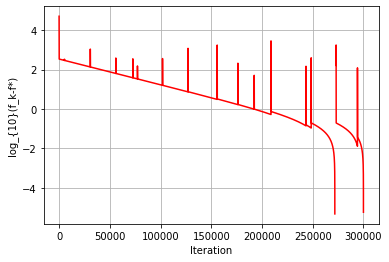

In [ ]:
## plot

import matplotlib.pyplot as plt

plt.plot([i for i in range(it)], [np.log10(i-lst_cost[-1]) for i in lst_cost[:-1]], 'b-', color='red')

plt.xlabel('Iteration')
plt.ylabel('log_{10}(f_k-f*)')
plt.grid(True)

### $R=\alpha ‖·‖_1$

In [ ]:
#--measure time to run code
start_time = time.time()

#-- create initial w0=0,b0=0
m,n=X_train_colon.shape
np.random.seed(3)
w0=np.random.rand(n,1)
b0=np.random.rand(1)
#--train--
task_colon=SVM(X_train_colon,y_train_colon)
w,b,lst_cost,it=task_colon.solver(key=3,w0=w0,b0=b0,learning_rate=0.000005,max_time=1000000,Reg=1)
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_colon['sub_R']=elapsed_time
print('Running time:',time_run_colon['sub_R'])

#- save w,b
result_colon['sub_R']=(w,b)

#--predict
y_predict_colon=task_colon.predict(X_test_colon)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_colon.reshape(-1,),y_test_colon.reshape(-1,))*100))




solved by unconstranted problem with Reg=l1-lorm
iter 1 cost: 50668.352056
iter 1001 cost: 337.322476
iter 2001 cost: 333.965058
iter 3001 cost: 330.641048
iter 4001 cost: 327.350112
iter 5001 cost: 324.091921
iter 6001 cost: 320.866150
iter 7001 cost: 317.676925
iter 8001 cost: 314.514984
iter 9001 cost: 311.384505
iter 10001 cost: 308.285174
iter 11001 cost: 305.216683
iter 12001 cost: 302.178724
iter 13001 cost: 299.170993
iter 14001 cost: 296.193189
iter 15001 cost: 293.245015
iter 16001 cost: 290.326176
iter 17001 cost: 287.436380
iter 18001 cost: 284.575339
iter 19001 cost: 281.742765
iter 20001 cost: 278.938375
iter 21001 cost: 276.161891
iter 22001 cost: 273.413032
iter 23001 cost: 270.691526
iter 24001 cost: 268.005994
iter 25001 cost: 265.338288
iter 26001 cost: 262.697127
iter 27001 cost: 260.082246
iter 28001 cost: 257.493383
iter 29001 cost: 254.930280
iter 30001 cost: 252.392681
iter 31001 cost: 249.880331
iter 32001 cost: 247.392979
iter 33001 cost: 244.930377
iter 34001

In [ ]:
sub_R_solution=np.vstack((result_colon['sub_R'][0],result_colon['sub_R'][1]))
primal_R_solution=np.vstack((result_colon['primal_R'][0],result_colon['primal_R'][1]))

print(' distance between sub_R solution and primal_R solution:', np.linalg.norm(sub_R_solution-primal_R_solution))

 distance between sub_R solution and primal_R solution: 0.759912487513211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


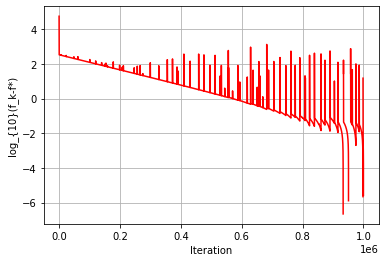

In [ ]:
## plot

import matplotlib.pyplot as plt

plt.plot([i for i in range(it)], [np.log10(i-lst_cost[-1]) for i in lst_cost[:-1]], 'b-', color='red')

plt.xlabel('Iteration')
plt.ylabel('log_{10}(f_k-f*)')
plt.grid(True)

## Task 3: Train by solve dual problem with $R=0$

In [ ]:
#--measure time to run code
start_time = time.time()

#-- create initial w0=0,b0=0
m,n=X_train_colon.shape
w0=np.zeros((n,1))
b0=0
#--train--
task_colon=SVM(X_train_colon,y_train_colon)
w,b=task_colon.solver(dual=2,key=4)
print('w:',w)
print('b:',b)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_colon['dual']=elapsed_time
print('Running time:',time_run_colon['dual'])

#- save w,b
result_colon['dual']=(w,b)

#--predict
y_predict_colon=task_colon.predict(X_test_colon)

#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_colon.reshape(-1,),y_test_colon.reshape(-1,))*100))




solved by dual problem with Reg=0
     pcost       dcost       gap    pres   dres
 0:  1.2948e+02 -5.7485e+03  1e+04  2e-02  1e-13
 1:  8.8080e+01 -3.9948e+02  8e+02  8e-04  6e-14
 2:  2.5113e+01 -3.2837e+01  6e+01  2e-16  7e-14
 3:  3.4634e+00 -4.1780e+00  8e+00  2e-16  3e-14
 4:  4.4513e-01 -6.5608e-01  1e+00  2e-16  2e-14
 5:  4.0596e-02 -1.1534e-01  2e-01  2e-16  4e-15
 6: -7.2293e-03 -2.7860e-02  2e-02  2e-16  1e-15
 7: -1.1225e-02 -1.2942e-02  2e-03  2e-16  7e-16
 8: -1.1559e-02 -1.1699e-02  1e-04  2e-16  5e-16
 9: -1.1606e-02 -1.1610e-02  4e-06  2e-16  6e-16
10: -1.1608e-02 -1.1608e-02  4e-08  2e-16  6e-16
11: -1.1608e-02 -1.1608e-02  4e-10  2e-16  5e-16
12: -1.1608e-02 -1.1608e-02  4e-12  2e-16  5e-16
Optimal solution found.
w: [[ 0.00313482]
 [-0.00064282]
 [-0.00246087]
 ...
 [-0.00445039]
 [-0.00216628]
 [-0.00490985]]
b: [-0.49607937]
Running time: 0.030321598052978516
accuracy:84.62 %


## Train by package sklearn.svm.SVC with $R=0$

In [ ]:
from sklearn.svm import SVC
#--measure time to run code
start_time = time.time()
print('solved by sklearn.svm.SVC')
C = 100
clf = SVC(kernel = 'linear', C = C)
clf.fit(X_train_colon, y_train_colon.reshape((-1,)))

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]
#-- save w,b
result_colon['sklearn']=(w_sklearn,b_sklearn)
print('w: ',w_sklearn)
print('b: ',b_sklearn)

#--measure time to run code
end_time = time.time()
elapsed_time = end_time - start_time
time_run_colon['sklearn']=elapsed_time
print('Running time:',time_run_colon['sklearn'])


#--predict
y_predict_colon = clf.predict(X_test_colon)


#--accuracy
print('accuracy:{:.2f} %'.format(accuracy_score(y_predict_colon.reshape(-1,),y_test_colon.reshape(-1,))*100))

solved by sklearn.svm.SVC
w:  [[ 0.00313429]
 [-0.00064252]
 [-0.00246048]
 ...
 [-0.00444992]
 [-0.00216481]
 [-0.00490751]]
b:  -0.49607343317600394
Running time: 0.013319730758666992
accuracy:84.62 %


## Compare running time

<BarContainer object of 6 artists>

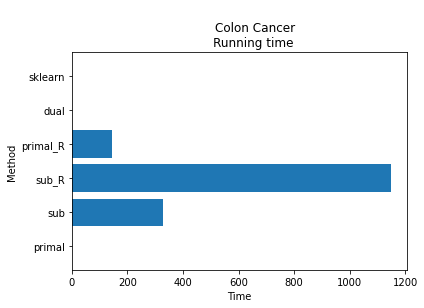

In [ ]:
fig, ax = plt.subplots()
# plt.style.use('fivethirtyeight')
ax.set( xlabel='Time', ylabel='Method',
       title='''
        Colon Cancer
       Running time''')
ax.barh(list(time_run_colon.keys()), list(time_run_colon.values()))

<BarContainer object of 4 artists>

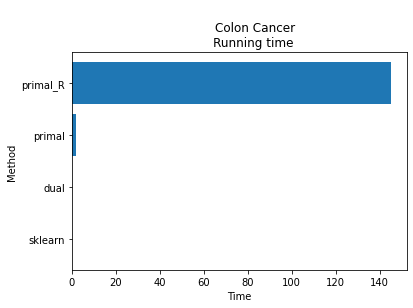

In [ ]:
fig, ax = plt.subplots()
# plt.style.use('fivethirtyeight')
ax.set( xlabel='Time', ylabel='Method',
       title='''
        Colon Cancer
       Running time''')
a=time_run_colon.items()
a=sorted(a,key= lambda x: x[1])
# print(a)
ax.barh([i[0] for i in a[:-2]], [i[1] for i in a[:-2]])